In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, log_loss, hinge_loss, accuracy_score
from sklearn.preprocessing import StandardScaler


# Load heart failure patients dataset
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')

# List of continuous features that need to be scaled
continu_features = ['age', 'ejection_fraction', 
                    'platelets', 'serum_creatinine', 
                    'serum_sodium', 'creatinine_phosphokinase', 'time']

# Initialize the StandardScaler
scaler = StandardScaler()
# Standardize the numerical features to have a mean of 0 and a standard deviation of 1
data[continu_features] = scaler.fit_transform(data[continu_features])

# Display information about the dataset, including column names, non-null counts, and data types
print("Dataset Info:")
print(data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    float64
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    float64
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    float64
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    float64
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(7), int64(6)
memory usage: 30.5 KB
None


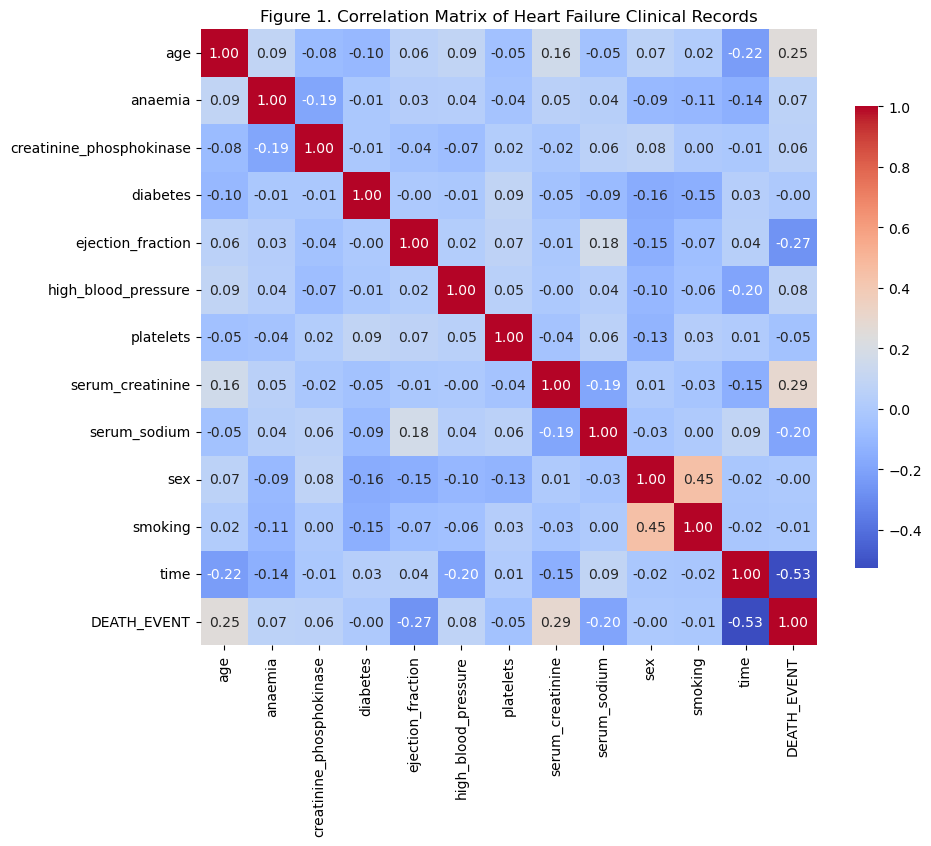

In [2]:
# Compute correlations
corr_matrix = data.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': 0.75})
plt.title('Figure 1. Correlation Matrix of Heart Failure Clinical Records')
plt.show()

In [3]:
# Define features and label
features = ['age', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']
X = data[features]
y = data['DEATH_EVENT']

# Split the dataset into training/validation and test sets (80% train/val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the sizes of the splits
print(f"Training/Validation set size: {X_train_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training/Validation set size: 239
Test set size: 60


In [4]:
# Define the parameter grid
param_grid_logistic = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],  # Keep only l2 for lbfgs
    'solver': ['lbfgs', 'saga']  # saga supports l1 and l2
}

# Add separate grid for l1 penalty with appropriate solvers
param_grid_logistic_l1 = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],  # Use l1 penalty
    'solver': ['liblinear', 'saga']  # Only liblinear and saga support l1
}

# Combine the grids into a list of dictionaries
param_grid_combined = [param_grid_logistic, param_grid_logistic_l1]

# Initialize GridSearchCV
logistic_grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_combined, cv=5, scoring='accuracy')
logistic_grid_search.fit(X_train_val, y_train_val)

# Use best estimator
logistic_model = logistic_grid_search.best_estimator_

# Display best parameters
print("Best parameters for Logistic Regression:", logistic_grid_search.best_params_)


Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [5]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  # range
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 'scale', 'auto']  
}


# Initialize GridSearchCV
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_val, y_train_val)

# Use best estimator
svc_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best hyperparameters chosen by GridSearchCV
print(f"Best hyperparameters for SVC: {best_params}")

Best hyperparameters for SVC: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}


In [6]:
# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Store results
logistic_train_errors = []
logistic_val_errors = []
logistic_01_losses = []
logistic_val_accuracies = []  # Store validation accuracies for logistic regression

svc_train_errors = []
svc_val_errors = []
svc_01_losses = []
svc_val_accuracies = []  # Store validation accuracies for SVC

# Store validation F1 scores
logistic_cv_scores = []
svc_cv_scores = []

# Loop through each fold
for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Convert labels for the current fold for SVC
    y_train_hinge = y_train.replace({0: -1, 1: 1})
    y_val_hinge = y_val.replace({0: -1, 1: 1})

    # Fit Logistic Regression
    logistic_model.fit(X_train, y_train)
    y_pred_logistic_val = logistic_model.predict(X_val)
    y_pred_logistic_train = logistic_model.predict(X_train)

    # Compute validation and training errors (logistic loss)
    val_loss_logistic = log_loss(y_val, logistic_model.predict_proba(X_val))
    train_loss_logistic = log_loss(y_train, logistic_model.predict_proba(X_train))
    
    logistic_val_errors.append(val_loss_logistic)
    logistic_train_errors.append(train_loss_logistic)
    
    # Compute 0/1 loss for Logistic Regression
    logistic_01_loss_fold = np.mean(y_val != y_pred_logistic_val)
    logistic_01_losses.append(logistic_01_loss_fold)

    # Compute validation accuracy for Logistic Regression
    logistic_val_accuracy = accuracy_score(y_val, y_pred_logistic_val)
    logistic_val_accuracies.append(logistic_val_accuracy)

    logistic_cv_scores.append(classification_report(y_val, y_pred_logistic_val, output_dict=True, zero_division=1)['1']['f1-score'])

    # Fit SVC
    svc_model.fit(X_train, y_train_hinge)
    y_pred_svc_val = svc_model.predict(X_val)
    y_pred_svc_train = svc_model.predict(X_train)

    # Compute validation and training errors (hinge loss)
    val_loss_svc = hinge_loss(y_val_hinge, svc_model.decision_function(X_val))
    train_loss_svc = hinge_loss(y_train_hinge, svc_model.decision_function(X_train))
    
    svc_val_errors.append(val_loss_svc)
    svc_train_errors.append(train_loss_svc)
    
    # Compute 0/1 loss for SVC
    svc_01_loss_fold = np.mean(y_val != y_pred_svc_val)
    svc_01_losses.append(svc_01_loss_fold)

    # Compute validation accuracy for SVC
    svc_val_accuracy = accuracy_score(y_val, y_pred_svc_val)
    svc_val_accuracies.append(svc_val_accuracy)

    svc_cv_scores.append(classification_report(y_val, y_pred_svc_val, output_dict=True, zero_division=1)['1']['f1-score'])

# Average training and validation errors
logistic_train_mean = np.mean(logistic_train_errors)
logistic_val_mean = np.mean(logistic_val_errors)
logistic_01_loss_mean = np.mean(logistic_01_losses)

svc_train_mean = np.mean(svc_train_errors)
svc_val_mean = np.mean(svc_val_errors)
svc_01_loss_mean = np.mean(svc_01_losses)

# Average validation accuracies
logistic_val_accuracy_mean = np.mean(logistic_val_accuracies)
svc_val_accuracy_mean = np.mean(svc_val_accuracies)

# Average CV scores
logistic_cv_mean = np.mean(logistic_cv_scores)
svc_cv_mean = np.mean(svc_cv_scores)

# Fit models on the entire training and validation set to calculate test loss
logistic_model.fit(X_train_val, y_train_val)
svc_model.fit(X_train_val, y_train_val.replace({0: -1, 1: 1}))  # Modify labels for SVC

# Calculate test loss
logistic_test_loss = log_loss(y_test, logistic_model.predict_proba(X_test))
svc_test_loss = hinge_loss(y_test.replace({0: -1, 1: 1}), svc_model.decision_function(X_test))

# Display results 
print("=" * 80)
print("                Model Evaluation Results                ")
print("=" * 80)
print(f"{'Metric':<30}{'Logistic Regression':<20}{'Support Vector Classifier':<20}")
print("=" * 80)
print(f"{'Training Error':<30}{logistic_train_mean:<20.4f}{svc_train_mean:<20.4f}")
print(f"{'Validation Error':<30}{logistic_val_mean:<20.4f}{svc_val_mean:<20.4f}")
print(f"{'Validation 0/1 Error':<30}{logistic_01_loss_mean:<20.4f}{svc_01_loss_mean:<20.4f}")
print(f"{'Validation Accuracy':<30}{logistic_val_accuracy_mean:<20.4f}{svc_val_accuracy_mean:<20.4f}")
print(f"{'Test Error':<30}{logistic_test_loss:<20.4f}{svc_test_loss:.4f}")
print("=" * 80)

                Model Evaluation Results                
Metric                        Logistic Regression Support Vector Classifier
Training Error                0.4081              0.3290              
Validation Error              0.4433              0.6623              
Validation 0/1 Error          0.1803              0.7950              
Validation Accuracy           0.8197              0.2050              
Test Error                    0.5105              0.6371
